<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/CosmicNeutrons/CosmicNeutronData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [ ]:
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'root_files_dzhadan')
#from utils import Utils
#util = Utils()
import math

S = pow(100*100, 2) #100x100 m2 in cm2 - simulated area

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

#Make dataframes

In [ ]:
CRYinput = {'Houston': 0.438068, 
            'Washington': 0.398198, 
            'Fremont': 0.408906, 
            'Leadville': 0.409181, 
            'YorkTown': 0.404541, 
            '2100_Leadville': 0.129099, 
            '11300_Fremont': 0.00381956, 
            'NYC': 0.414551, 
            '2100M_g': 0.126252}
def makeCRYpandas():
  df = pd.DataFrame()
  for _CRYinput in CRYinput:
    print(_CRYinput, CRYinput[_CRYinput])
    df_ = pd.read_csv('drive/MyDrive/root_files_dzhadan/CRY/%s.txt'%_CRYinput, sep=", ", header=None, engine='python')
    df_.columns = ["evt", "pdgId", "energy"]
    df_['name'] = _CRYinput
    df_ = df_.dropna()
    df = df.append(df_.query('pdgId==2112'))
  return df

dfCRY = makeCRYpandas()

Houston 0.438068
Washington 0.398198
Fremont 0.408906
Leadville 0.409181
YorkTown 0.404541
2100_Leadville 0.129099
11300_Fremont 0.00381956
NYC 0.414551
2100M_g 0.126252


In [ ]:
Papers = {'TinoHeijmen': 'Radiation-induced soft errors in digital circuits', 
          'DarioBisello': 'Neutron production targets for a new Single Event Effects facility at the 70 MeV Cyclotron of LNL-INFN ',
          'DarioBiselloV2': 'Neutron production targets for a new Single Event Effects facility at the 70 MeV Cyclotron of LNL-INFN '}

def makeDataPandas():
  df = pd.DataFrame()
  for paper in Papers:
    df_ = pd.read_csv('drive/MyDrive/root_files_dzhadan/CRY/NeutronFluxData_%s.csv'%paper, sep="[;,]", header=None)
    df_.columns = ["energy", "flux"]
    df_['name'] = paper
    df = df.append(df_)
  return df

dfData = makeDataPandas()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


#Make plots

In [ ]:
dfData_ = dfData.query('name == "DarioBisello" & energy>100')

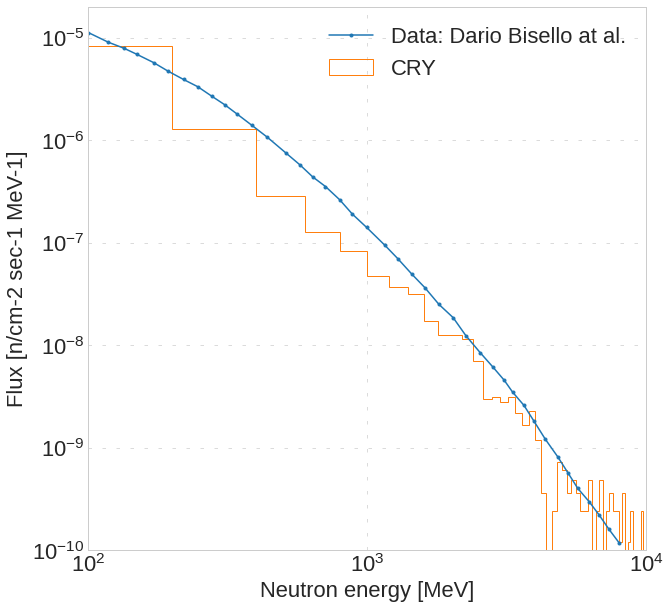

In [ ]:
from scipy.interpolate import interp1d

plt.figure(figsize=(10,10))
plt.plot(dfData_.energy, dfData_.flux, '.-', label='Data: Dario Bisello at al.')
(counts, bins) = np.histogram(dfCRY.query('name=="NYC"')['energy'], bins=np.arange(0, 10000, 200))
binSize = bins[1]-bins[0]
timeArea = (CRYinput["NYC"]*S*binSize)
counts = counts/timeArea
plt.hist(bins[:-1], bins, weights=counts, histtype='step', label="CRY")
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.ylim(1e-10, 2e-5)
plt.xlim(100, 10000)
plt.xlabel('Neutron energy [MeV]')
plt.ylabel('Flux [n/cm-2 sec-1 MeV-1]');

No handles with labels found to put in legend.


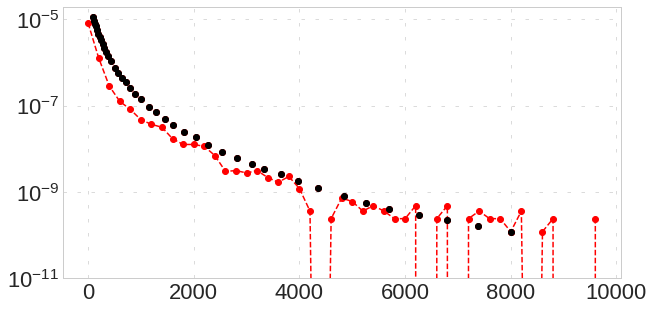

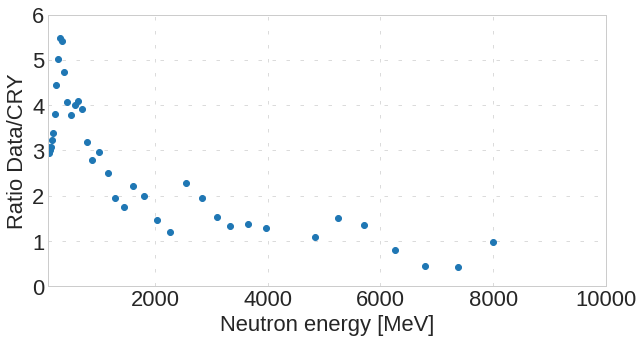

In [ ]:
x = bins[:-1]
y = counts
fCRY = interp1d(x, y, kind='cubic')
fData = interp1d(dfData_.energy, dfData_.flux, kind='cubic')
plt.plot(x, y, 'ro')
plt.plot(x, fCRY(x), 'r--')
plt.plot(dfData_.energy, fData(dfData_.energy), 'ro')
plt.plot(dfData_.energy, dfData_.flux, 'ko')
plt.yscale('log')
plt.ylim(1e-11, 2e-5)

plt.figure()
plt.plot(dfData_.energy, dfData_.flux/fCRY(dfData_.energy), 'o')
plt.ylim(0, 6)
plt.xlim(100, 10000)
plt.xlabel('Neutron energy [MeV]')
plt.ylabel('Ratio Data/CRY');
plt.legend()

#Plot CRY4

In [ ]:
def GetNeutKE(df):
  nmass = 936 # MeV, neutron mass
  df_neut = df.query('demcgen_pdg==2112')
  mom2 = df_neut.demcgen_momx*df_neut.demcgen_momx+df_neut.demcgen_momy*df_neut.demcgen_momy+df_neut.demcgen_momz*df_neut.demcgen_momz
  en2 = mom2 + nmass*nmass
  ke = np.sqrt(en2.to_numpy()) - nmass 
  return ke

In [ ]:
h5file='drive/MyDrive/root_files_dzhadan/cry4df_9000.h5'
df = pd.read_hdf(h5file, mode='r')

In [ ]:
TMIN = -125
TMAX = 50
PMIN_EXT = 90
PMAX_EXT = 140
PMIN_PHY = 103.85
PMAX_PHY = 105.1

#Default MDC-style cut box
cuts = [
    "(de_status > 0)",
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 105)",
    "((deent_d0 + 2./deent_om) > 450)",
    "((deent_d0 + 2./deent_om) < 680)",
    "(is_triggered)"
]
cut_tbox = " & ".join(cuts)

#PID, TrkQual and cut on events with an usptream leg
cuts = [
    "(dequal_TrkQual > 0.8)",
    "(dequal_TrkPID > 0.95)",
    "(ue_status <= 0)"
]
cut_pid_trkqual_ue = " & ".join(cuts)

# Extended momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_EXT,
    "(deent_mom < %f)" % PMAX_EXT
]
cut_extmom = " & ".join(cuts)

# Physics momentum window cut`
cuts = [
    "(deent_mom > %f)" % PMIN_PHY,
    "(deent_mom < %f)" % PMAX_PHY,
]
cut_phymom = " & ".join(cuts)

# Loose box cuts
cuts = [
    "(deent_td > 0.577350)",
    "(deent_td < 1.000)",
    "(deent_d0 > -80)",
    "(deent_d0 < 205)",
    "((deent_d0 + 2./deent_om) > 450)",
    "(is_triggered)"
]
cut_lbox = " & ".join(cuts)


crv_time = "( crvinfo__dT < %d | crvinfo__dT > %d)" % (TMIN, TMAX)
#Combime cuts
cut_nomom  = cut_tbox +" & "+cut_pid_trkqual_ue
cut_extmom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_extmom
cut_phymom = cut_tbox +" & "+cut_pid_trkqual_ue+" & "+cut_phymom
cut_loose  = cut_lbox +" & "+cut_pid_trkqual_ue

cut_current = cut_extmom+" & "+crv_time

(0.0, 20000.0)

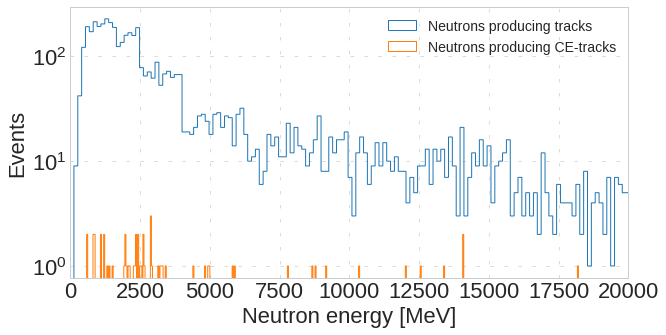

In [ ]:
plt.xlabel('Neutron energy [MeV]')
plt.ylabel('Events')
plt.hist(GetNeutKE(df), histtype='step', bins=1000, label='Neutrons producing tracks');
plt.hist(GetNeutKE(df.query(cut_current)), histtype='step', bins=1000, label='Neutrons producing CE-tracks');
plt.legend(prop={'size': 14})
plt.yscale('log')
plt.xlim(0, 20000)